In [1]:
# Librerías
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Extracción de datos
archivos = ['Acero_304.csv', 'Pb.csv', 'Intensidades.csv']
folder_path = './datos/'

Pb_data = pd.read_csv(folder_path + 'Pb.csv')
Acero_data = pd.read_csv(folder_path + 'Acero_304.csv')
Intensidad_data = pd.read_csv(folder_path + 'Intensidades.csv')

In [3]:
Intensidad_data

,d#1 / mm,n_Cs137#1,d#2 / mm,n_Cs137#2
0,0,43335,0,43614
1,5,24479,5,32983
2,10,14326,10,24847
3,15,8180,15,18506
4,20,4441,20,14534
5,25,2883,25,10979
6,30,1743,30,7950
7,35,1227,35,6187


In [4]:
# Datos
conteos = {
    'Pb': Pb_data.iloc[:, 1::2].to_numpy(dtype=np.uint32).transpose(),
    'Acero': Acero_data.iloc[:, 1::2].to_numpy(dtype=np.uint32).transpose(),
}

E = Pb_data.iloc[:, 0].to_numpy(dtype=np.float64)  # [keV]

x = Intensidad_data.iloc[:, 0].to_numpy(dtype=np.float64) / 10  # [cm]

intensidades = {
    'Pb': Intensidad_data['n_Cs137#1'].to_numpy(dtype=np.uint32),
    'Acero': Intensidad_data['n_Cs137#2'].to_numpy(dtype=np.uint32),
}

In [18]:
# Colores
colors_Pb = ['#0000ff', '#1111df', '#2121c0', '#2d2da4',
             '#39398e', '#414176', '#484860', '#4d4d4d']

colors_Acero = ['#ff8c00', '#df8211', '#c07821', '#a46f2d',
                '#8e6839', '#765e41', '#605548', '#4d4d4d']

FloatSlider(value=0.0, continuous_update=False, description='Espesor:', max=3.5, step=0.5)

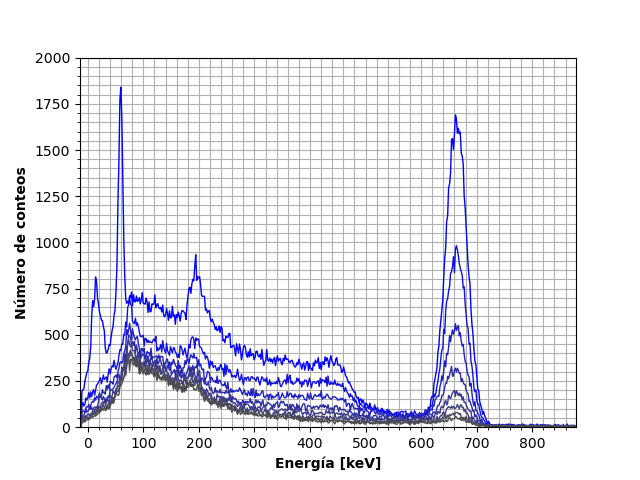

In [60]:
%matplotlib widget

slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=3.5,
    step=0.5,
    description='Espesor:',
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

display(slider)

curves = []
fig, ax = plt.subplots()#layout='constrained')
for N, color, espesor in zip(conteos['Pb'], colors_Pb, x):
    lbl = f'Espesor$ = {espesor:.1f}$ cm'
    curves += ax.plot(E[:-1], N[:-1], lw=1, c=color, label=lbl)

ax.set_xlim([E[0], E[-2]])
ax.set_ylim([0, 2000])
ax.minorticks_on()
ax.grid(True, which='both', zorder=0)
ax.set_xlabel('Energía [keV]', fontweight='bold')
ax.set_ylabel('Número de conteos', fontweight='bold')

fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.185),
    ncols=3,
    fancybox=True,
    shadow=True,
)
plt.savefig("graficas\\espectro_plomo.pdf", format="pdf", bbox_inches='tight')
plt.show()


def select_curve(change):
    selected_val = change['new']
    for i, curve in enumerate(curves):
        if i == int(selected_val * 2):
            curve.set_alpha(1)
        else:
            curve.set_alpha(0.4)
    fig.canvas.draw_idle()


slider.observe(select_curve, names='value')

FloatSlider(value=0.0, continuous_update=False, description='Espesor:', max=3.5, step=0.5)

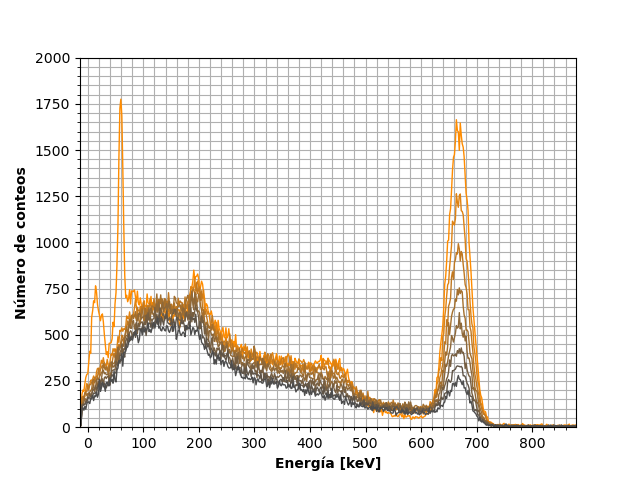

In [61]:
slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=3.5,
    step=0.5,
    description='Espesor:',
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

display(slider)

curves = []
fig, ax = plt.subplots()layout='constrained')
for N, color, espesor in zip(conteos['Acero'], colors_Acero, x):
    lbl = f'Espesor$ = {espesor:.1f}$ cm'
    curves += ax.plot(E[:-1], N[:-1], lw=1, c=color, label=lbl)

ax.set_xlim([E[0], E[-2]])
ax.set_ylim([0, 2000])
ax.minorticks_on()
ax.grid(True, which='both', zorder=0)
ax.set_xlabel('Energía [keV]', fontweight='bold')
ax.set_ylabel('Número de conteos', fontweight='bold')

fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.185),
    ncols=3,
    fancybox=True,
    shadow=True,
)
plt.savefig("graficas\\espectro_acero.pdf", format="pdf", bbox_inches='tight')
plt.show()


def select_curve(change):
    selected_val = change['new']
    for i, curve in enumerate(curves):
        if i == int(selected_val * 2):
            curve.set_alpha(1)
        else:
            curve.set_alpha(0.4)
    fig.canvas.draw_idle()


slider.observe(select_curve, names='value')

In [59]:
plt.close('all')